In [6]:
import numpy as np

import pandas as pd

import os
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import mean_squared_error

In [7]:
df=pd.read_csv("/content/stock price prediction daata.csv")

In [8]:
df.head()

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TIMESTAMP,TOTALTRADES,ISIN
0,20MICRONS,EQ,37.80,37.80,36.15,36.85,37.40,37.05,27130,994657.90,2017-06-28,202,INE144J01027
1,3IINFOTECH,EQ,4.10,4.85,4.00,4.55,4.65,4.05,20157058,92148517.65,2017-06-28,7353,INE748C01020
2,3MINDIA,EQ,13425.15,13469.55,12920.00,13266.70,13300.00,13460.55,2290,30304923.35,2017-06-28,748,INE470A01017
3,63MOONS,EQ,61.00,61.90,60.35,61.00,61.10,60.65,27701,1689421.00,2017-06-28,437,INE111B01023
4,8KMILES,EQ,546.10,548.00,535.00,537.45,535.20,547.45,79722,43208620.05,2017-06-28,1866,INE650K01021


In [9]:


df.shape

(846404, 13)

In [10]:
df.describe()

,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TOTALTRADES
count,846404.000000,846404.000000,846404.000000,846404.000000,846404.000000,846404.000000,8.464040e+05,8.464040e+05,8.464040e+05
mean,561.258797,568.679340,553.861861,560.815168,560.184430,560.225320,6.983800e+05,1.334592e+08,5.013823e+03
std,2005.760598,2027.159199,1983.412783,2004.576315,2003.900793,2000.362761,4.055630e+06,6.296968e+08,1.490112e+04
min,0.050000,0.050000,0.050000,0.050000,0.000000,0.050000,1.000000e+00,5.000000e-02,1.000000e+00
25%,39.900000,40.850000,38.850000,39.750000,39.600000,39.700000,6.628000e+03,6.071941e+05,8.400000e+01
50%,139.200000,142.050000,136.150000,138.900000,138.450000,138.750000,4.429200e+04,5.321067e+06,6.000000e+02
75%,490.000000,499.550000,481.100000,489.550000,488.500000,489.150000,2.757322e+05,3.711093e+07,3.028000e+03
max,119990.000000,119990.000000,119990.000000,119990.000000,119990.000000,119990.000000,7.818365e+08,1.426400e+11,1.192900e+06


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846404 entries, 0 to 846403
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   SYMBOL       846404 non-null  object 
 1   SERIES       843947 non-null  object 
 2   OPEN         846404 non-null  float64
 3   HIGH         846404 non-null  float64
 4   LOW          846404 non-null  float64
 5   CLOSE        846404 non-null  float64
 6   LAST         846404 non-null  float64
 7   PREVCLOSE    846404 non-null  float64
 8   TOTTRDQTY    846404 non-null  int64  
 9   TOTTRDVAL    846404 non-null  float64
 10  TIMESTAMP    846404 non-null  object 
 11  TOTALTRADES  846404 non-null  int64  
 12  ISIN         846404 non-null  object 
dtypes: float64(7), int64(2), object(4)
memory usage: 83.9+ MB


In [12]:
df.isnull().sum()

,0
SYMBOL,0
SERIES,2457
OPEN,0
HIGH,0
LOW,0
CLOSE,0
LAST,0
PREVCLOSE,0
TOTTRDQTY,0
TOTTRDVAL,0


In [13]:
# df=df[['TIMESTAMP','CLOSE']]
df['TIMESTAMP']=pd.to_datetime(df['TIMESTAMP'])
df.set_index('TIMESTAMP',inplace=True)

In [14]:
df.columns

Index(['SYMBOL', 'SERIES', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'LAST', 'PREVCLOSE',
       'TOTTRDQTY', 'TOTTRDVAL', 'TOTALTRADES', 'ISIN'],
      dtype='object')

In [15]:
numeric_col=['OPEN','HIGH','LOW','CLOSE','LAST','PREVCLOSE','TOTTRDQTY','TOTTRDVAL','TOTALTRADES']
df[numeric_col]=df[numeric_col].apply(pd.to_numeric,errors='coerce')

In [16]:
df[numeric_col]

,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TOTALTRADES
TIMESTAMP,,,,,,,,,
2017-06-28,37.80,37.80,36.15,36.85,37.40,37.05,27130,994657.90,202
2017-06-28,4.10,4.85,4.00,4.55,4.65,4.05,20157058,92148517.65,7353
2017-06-28,13425.15,13469.55,12920.00,13266.70,13300.00,13460.55,2290,30304923.35,748
2017-06-28,61.00,61.90,60.35,61.00,61.10,60.65,27701,1689421.00,437
2017-06-28,546.10,548.00,535.00,537.45,535.20,547.45,79722,43208620.05,1866
...,...,...,...,...,...,...,...,...,...
2017-12-29,221.00,221.00,214.00,217.00,217.00,220.00,14000,3041550.00,14
2017-12-29,562.00,562.00,549.55,550.80,552.00,556.80,105184,58163061.60,2218
2017-12-29,255.50,258.40,252.50,253.25,253.00,254.10,90067,22968100.60,2001


In [17]:
df['price_range']=df['HIGH']-df['LOW']
df['price_range']

,price_range
TIMESTAMP,
2017-06-28,1.65
2017-06-28,0.85
2017-06-28,549.55
2017-06-28,1.55
2017-06-28,13.00
...,...
2017-12-29,7.00
2017-12-29,12.45
2017-12-29,5.90


In [18]:
# Add a column for percentage change from previous close to current close
df['pct_change']=((df['CLOSE']-df['PREVCLOSE'])/df['PREVCLOSE'])*100
df['pct_change']

,pct_change
TIMESTAMP,
2017-06-28,-0.539811
2017-06-28,12.345679
2017-06-28,-1.440134
2017-06-28,0.577082
2017-06-28,-1.826651
...,...
2017-12-29,-1.363636
2017-12-29,-1.077586
2017-12-29,-0.334514


In [19]:
duplicates = df.duplicated().sum()
duplicates

524

In [20]:
df[df.duplicated()]

,SYMBOL,SERIES,OPEN,HIGH,LOW,CLOSE,LAST,PREVCLOSE,TOTTRDQTY,TOTTRDVAL,TOTALTRADES,ISIN,price_range,pct_change
TIMESTAMP,,,,,,,,,,,,,,
2017-05-12,NTPC,N2,1325.00,1325.00,1325.00,1325.00,1325.00,1325.0,1,1325.0,1,INE733E07JF7,0.0,0.000000
2017-08-16,NTPC,N2,1325.00,1325.00,1325.00,1325.00,1325.00,1325.0,1,1325.0,1,INE733E07JF7,0.0,0.000000
2017-08-03,NTPC,N2,1325.00,1325.00,1325.00,1325.00,1325.00,1325.0,1,1325.0,1,INE733E07JF7,0.0,0.000000
2017-06-20,NTPC,N2,1325.00,1325.00,1325.00,1325.00,1325.00,1325.0,1,1325.0,1,INE733E07JF7,0.0,0.000000
2017-10-25,UNITEDPOLY,SM,29.00,29.00,29.00,29.00,29.00,28.5,3000,87000.0,1,INE368U01011,0.0,1.754386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-23,KKVAPOW,SM,327.00,327.00,327.00,327.00,327.00,325.0,400,130800.0,1,INE239T01016,0.0,0.615385
2016-09-23,NET4,EQ,1.75,1.75,1.75,1.75,1.75,1.8,100,175.0,1,INE553E01012,0.0,-2.777778
2016-09-23,PARAPRINT,BZ,1.00,1.00,1.00,1.00,1.00,1.0,100,100.0,1,INE702L01010,0.0,0.000000


In [21]:
df=df.drop_duplicates()

In [22]:
df.shape

(845880, 14)

In [23]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


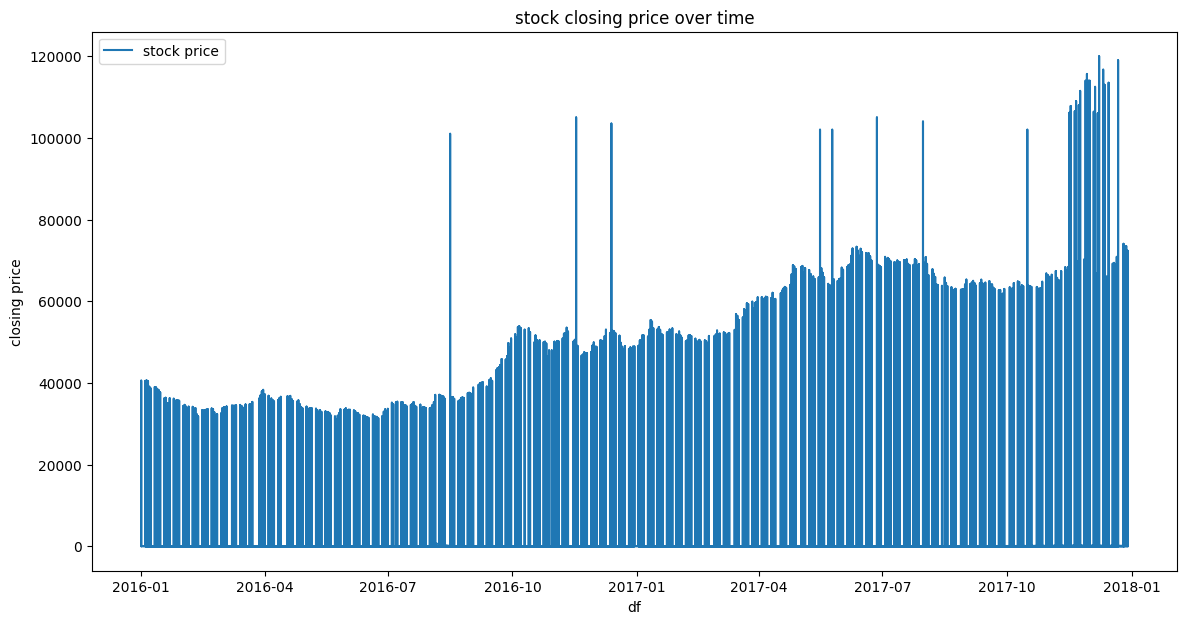

In [24]:
plt.figure(figsize=(14,7))
plt.plot(df[['CLOSE']],label='stock price')
plt.title('stock closing price over time')
plt.xlabel('df')
plt.ylabel('closing price')
plt.legend()
plt.show()

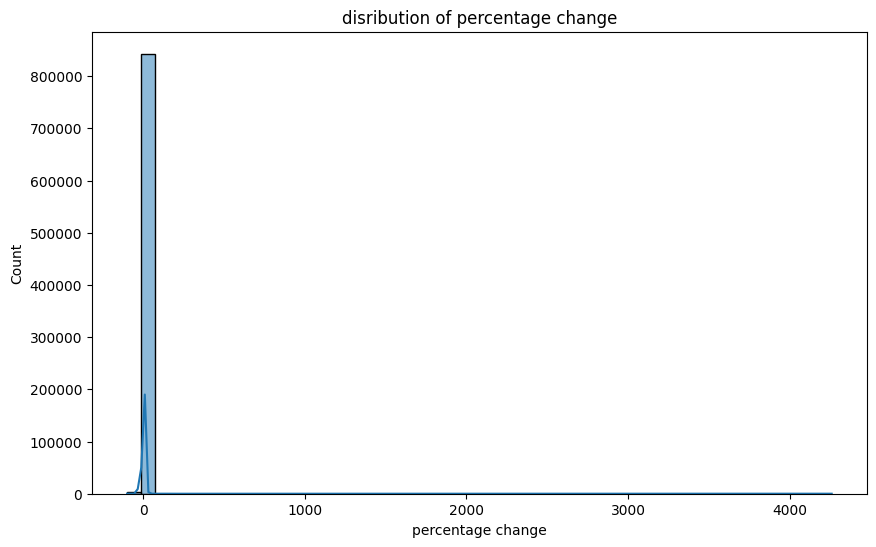

In [25]:
plt.figure(figsize=(10,6))
sns.histplot(df['pct_change'],bins=50,kde=True)
plt.xlabel('percentage change')
plt.title('disribution of percentage change')
plt.show()

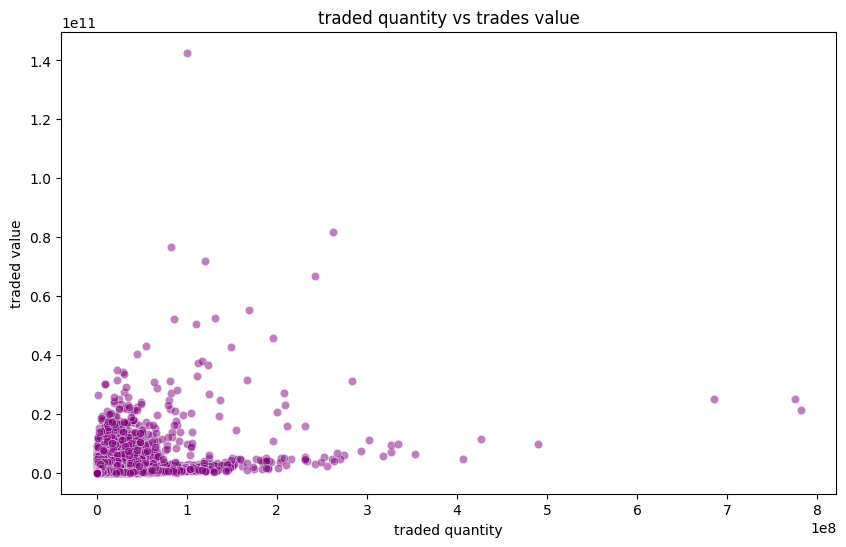

In [26]:
# Scatter plot of traded quantity vs. traded value
plt.figure(figsize=(10,6))
sns.scatterplot(x='TOTTRDQTY',y='TOTTRDVAL',data=df,color='purple',alpha=0.5)
plt.xlabel('traded quantity')
plt.ylabel('traded value')
plt.title('traded quantity vs trades value')
plt.show()



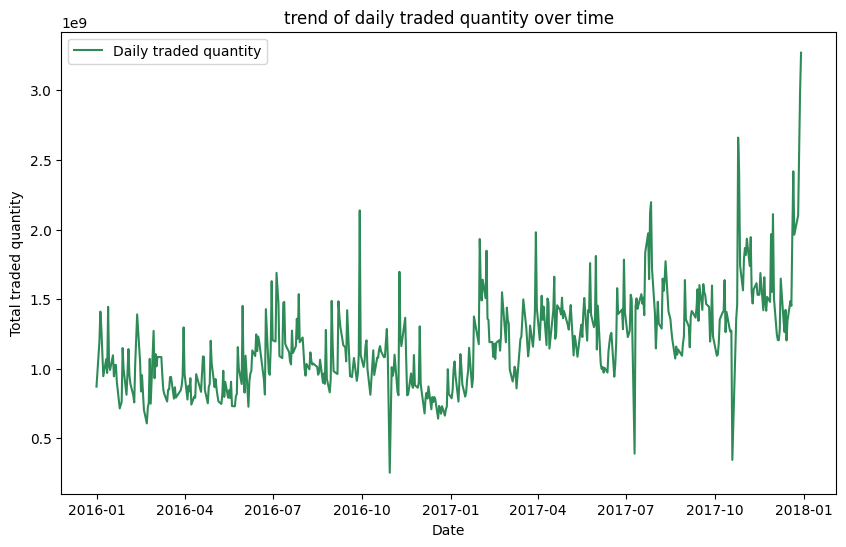

In [27]:
daily_traded_qty=df.groupby('TIMESTAMP')['TOTTRDQTY'].sum().reset_index()

plt.figure(figsize=(10,6))
plt.plot(daily_traded_qty['TIMESTAMP'],daily_traded_qty['TOTTRDQTY'],color='seagreen',label='Daily traded quantity')
plt.xlabel('Date')
plt.ylabel('Total traded quantity')
plt.title('trend of daily traded quantity over time')
plt.legend()
plt.show()

In [28]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(df['CLOSE'].values.reshape(-1,1))

In [29]:
time_step=60
def create_sequence(df,time_step):
  x,y=[],[]
  for i in range(len(df)-time_step):
    x.append(df[i:i+time_step,0])
    y.append(df[i+time_step,0])
  return np.array(x),np.array(y)

In [30]:
x,y=create_sequence(scaled_data,time_step)
x=np.reshape(x,(x.shape[0],x.shape[1],1))

In [31]:
x

array([[[3.06692352e-04],
        [3.75031409e-05],
        [1.10564676e-01],
        ...,
        [3.15651436e-03],
        [1.42845297e-03],
        [2.71689421e-03]],

       [[3.75031409e-05],
        [1.10564676e-01],
        [5.07959208e-04],
        ...,
        [1.42845297e-03],
        [2.71689421e-03],
        [1.52512773e-04]],

       [[1.10564676e-01],
        [5.07959208e-04],
        [4.47870843e-03],
        ...,
        [2.71689421e-03],
        [1.52512773e-04],
        [2.12517798e-05]],

       ...,

       [[6.57138369e-04],
        [2.92774520e-03],
        [6.31719573e-04],
        ...,
        [3.68364184e-04],
        [1.80806809e-03],
        [4.58996774e-03]],

       [[2.92774520e-03],
        [6.31719573e-04],
        [5.45003977e-03],
        ...,
        [1.80806809e-03],
        [4.58996774e-03],
        [2.11017673e-03]],

       [[6.31719573e-04],
        [5.45003977e-03],
        [1.65430521e-04],
        ...,
        [4.58996774e-03],
        [2.1101

In [32]:
train_size=int(len(x)*0.8)
x_train,y_train=x[:train_size],y[:train_size]
x_test,y_test=x[train_size:],y[train_size:]

In [33]:
model=Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
history=model.fit(x_train,y_train,epochs=50,batch_size=32,validation_data=(x_test,y_test),verbose=1)

Epoch 1/50
21146/21146 ━━━━━━━━━━━━━━━━━━━━ 188s 9ms/step - loss: 3.1117e-04 - val_loss: 1.9588e-04
Epoch 2/50
21146/21146 ━━━━━━━━━━━━━━━━━━━━ 198s 9ms/step - loss: 3.1316e-04 - val_loss: 1.9483e-04
Epoch 3/50
21146/21146 ━━━━━━━━━━━━━━━━━━━━ 203s 9ms/step - loss: 2.9480e-04 - val_loss: 1.9363e-04
Epoch 4/50
21146/21146 ━━━━━━━━━━━━━━━━━━━━ 200s 9ms/step - loss: 2.8965e-04 - val_loss: 1.8814e-04
Epoch 5/50
21146/21146 ━━━━━━━━━━━━━━━━━━━━ 184s 9ms/step - loss: 2.7083e-04 - val_loss: 1.9187e-04
Epoch 6/50
21146/21146 ━━━━━━━━━━━━━━━━━━━━ 199s 9ms/step - loss: 2.9398e-04 - val_loss: 1.9555e-04
Epoch 7/50
21146/21146 ━━━━━━━━━━━━━━━━━━━━ 181s 9ms/step - loss: 3.0627e-04 - val_loss: 1.9447e-04
Epoch 8/50
21146/21146 ━━━━━━━━━━━━━━━━━━━━ 201s 9ms/step - loss: 2.7671e-04 - val_loss: 2.3383e-04
Epoch 9/50
21146/21146 ━━━━━━━━━━━━━━━━━━━━ 202s 9ms/step - loss: 2.7214e-04 - val_loss: 1.9400e-04
Epoch 10/50
21146/21146 ━━━━━━━━━━━━━━━━━━━━ 181s 9ms/step - loss: 2.8376e-04 - val_loss: 1.8585e-04

In [35]:
predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

actual_prices=scaler.inverse_transform(y_test.reshape(-1,1))

rmse=np.sqrt(mean_squared_error(actual_prices,predicted_prices))
print(f"root meam squared error (RMSE):{rmse}")

5287/5287 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step
root meam squared error (RMSE):943.8291178578693


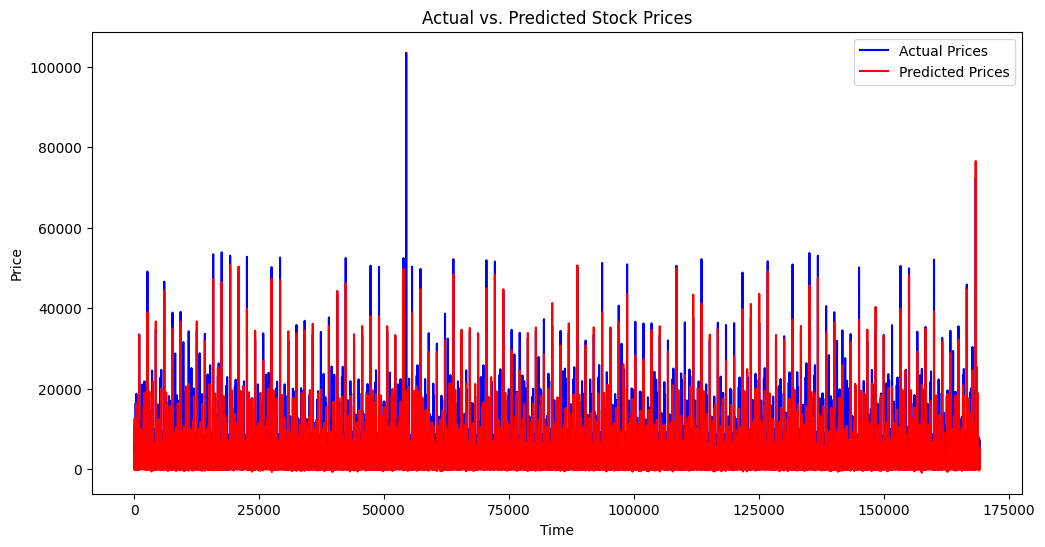

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Prices", color="blue")
plt.plot(predicted_prices, label="Predicted Prices", color="red")
plt.title("Actual vs. Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [37]:
from sklearn.metrics import r2_score

r2 = r2_score(actual_prices, predicted_prices)
print(f"R-squared (R2): {r2}")

R-squared (R2): 0.6881169854656781


In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [39]:
early_stopping
